In [1]:
# #downloading all codes & models
# !git clone https://github.com/ZhengPeng7/BiRefNet.git
# !pip uninstall -q torchaudio torchdata torchtext -y
# !pip install -q -r BiRefNet/requirements.txt
# !pip install -q -U gdown
# # BiRefNet-massive-epoch_240.pth
# !gdown 1KRVE-U3OHrUuuFPY4FFdE4eYBeHJSA0H
# # BiRefNet-massive-bb_swin_v1_tiny-epoch_235.pth
# !gdown 16gDZISjNp7rKi5vsJm6_fbYF8ZBK8AoF
# %cd BiRefNet

In [2]:
import os
import argparse
from glob import glob
from tqdm import tqdm
import cv2
import torch
from torch import nn
from dataset import MyData
from models.birefnet import BiRefNet
from utils import save_tensor_img, check_state_dict , path_to_image
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display


model = BiRefNet(bb_pretrained=False)
state_dict = torch.load(
    [
        "BiRefNet-massive-epoch_240.pth",
        "BiRefNet-massive-bb_swin_v1_tiny-epoch_235.pth"
    ][0],
    map_location='cpu'
)
state_dict = check_state_dict(state_dict)
model.load_state_dict(state_dict)
model.eval()
model = model.to('cuda')

/home/def/miniforge3/envs/dis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.set_float32_matmul_precision(['high', 'highest'][0])

In [4]:
import numpy as np

In [5]:
from torchvision import transforms


transform_image = transforms.Compose([
    transforms.Resize((1024,1024)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def tensor_to_pil(tenor_im):
    im = tenor_im.cpu().clone()
    im = im.squeeze(0)
    tensor2pil = transforms.ToPILImage()
    im = tensor2pil(im)
    return im

def singleImageoutput(image):
    secondimage = image.copy()
    input_images = transform_image(image).unsqueeze(0).to('cuda')
    with torch.no_grad():
        scaled_preds = model(input_images)[-1].sigmoid()
    for idx_sample in range(scaled_preds.shape[0]):
        res = nn.functional.interpolate(
            scaled_preds[idx_sample].unsqueeze(0),
            size=secondimage.size,
            mode='bilinear',
            align_corners=True
        )
    output=tensor_to_pil(res)   # test set dir + file name

    secondimage.putalpha(output)
    return secondimage

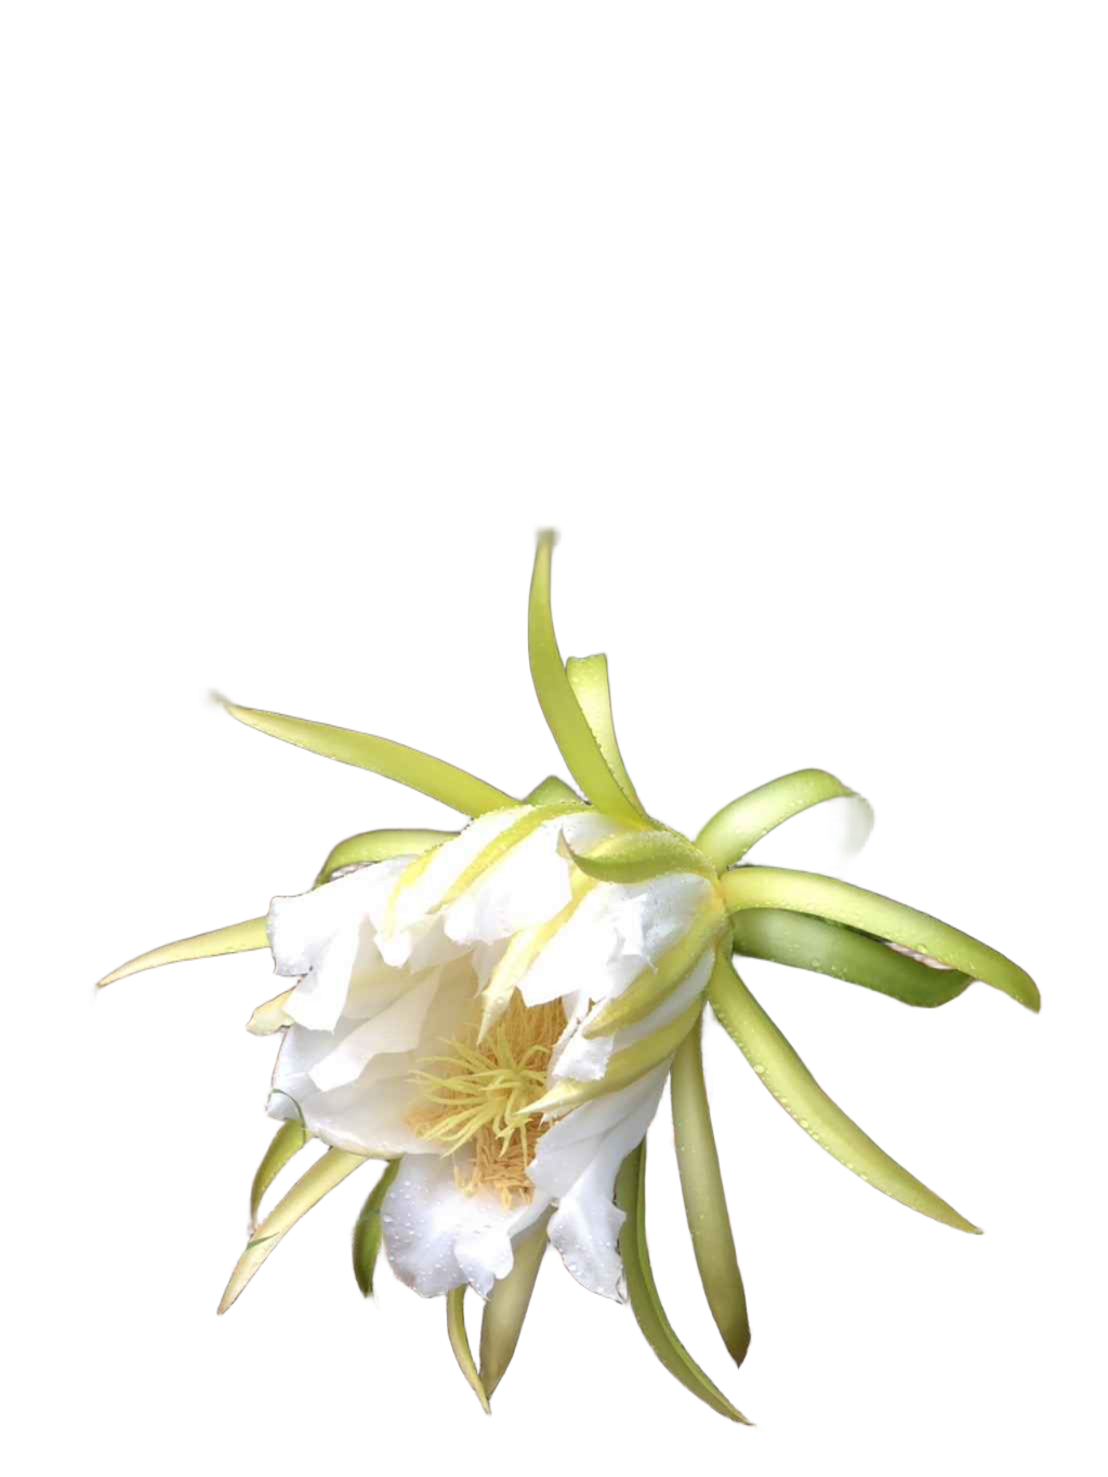

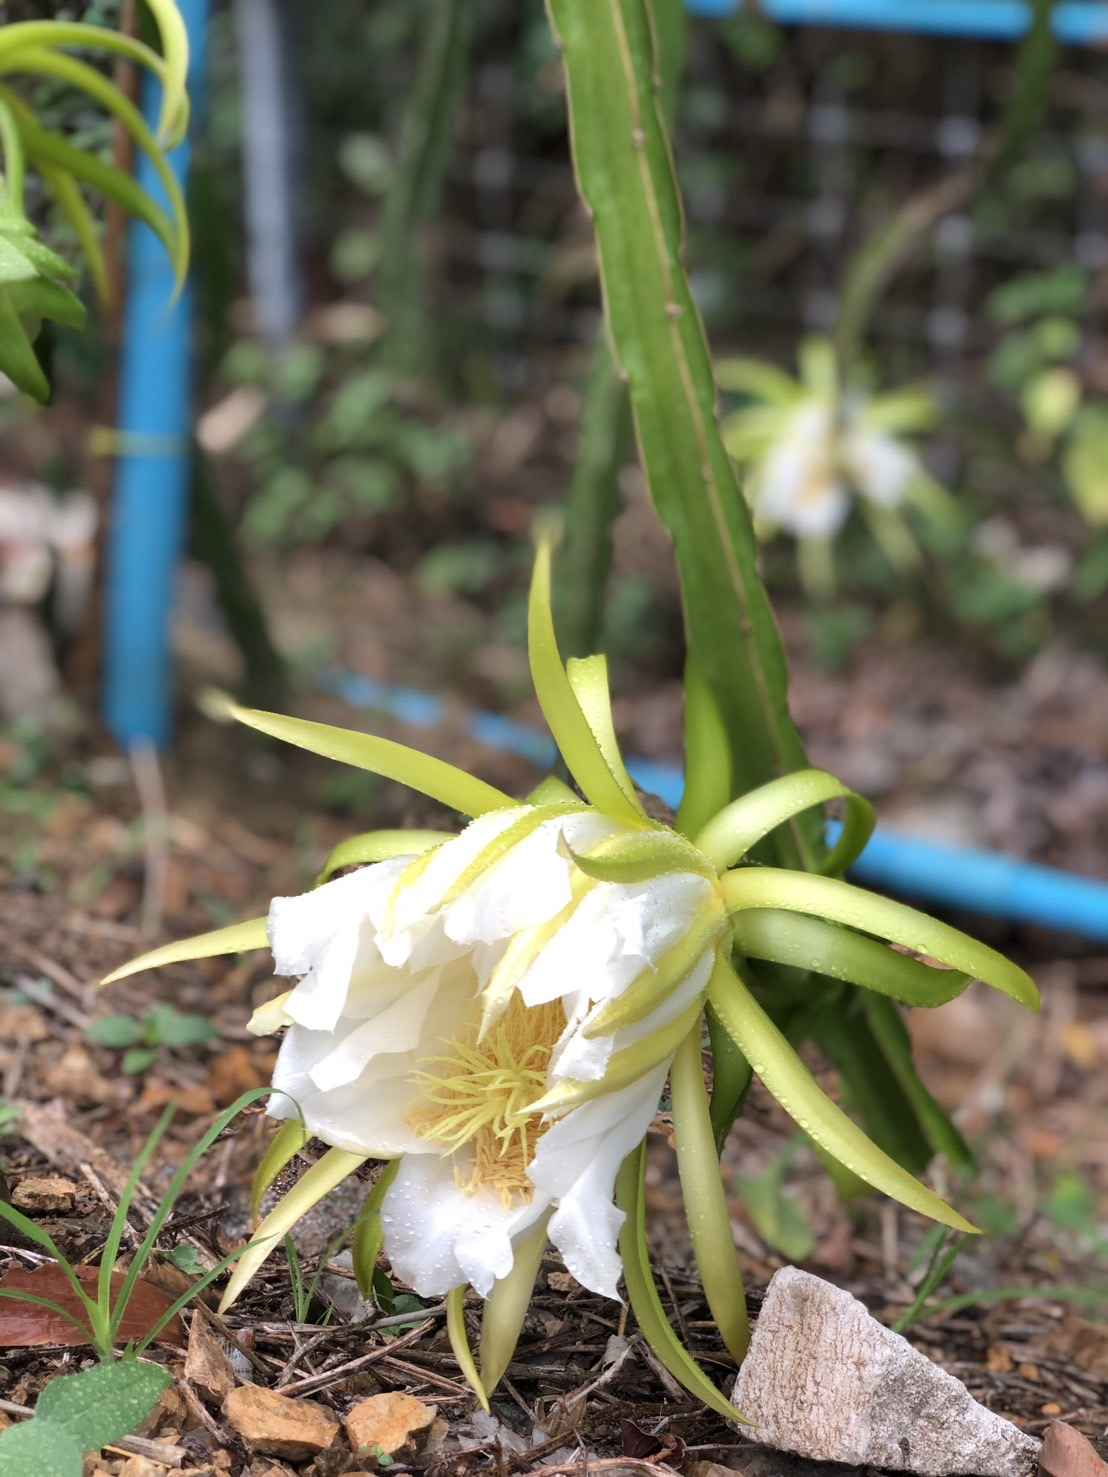

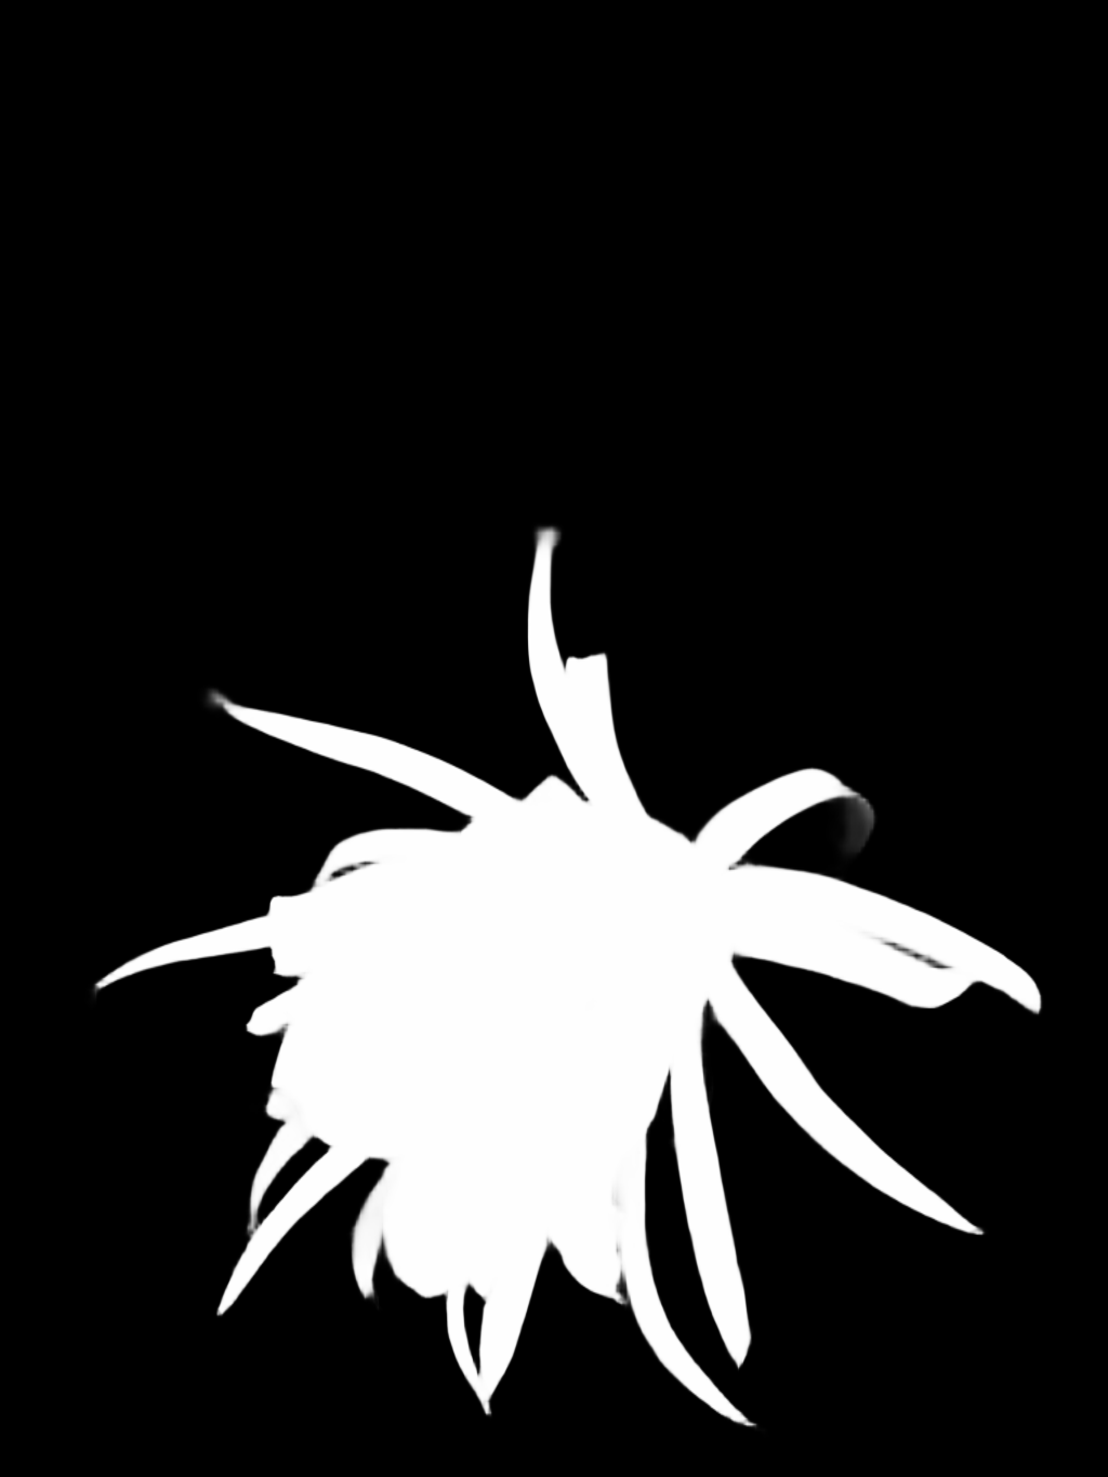

In [7]:
#upload image and paste the path here
imagepath = 'input/flow.jpg'
image = Image.open(imagepath)
output = singleImageoutput(image.resize((1024,1024))).resize(image.size)
display(output)
display(image)
display(output.split()[3])

In [8]:
import matplotlib.pyplot as plt
from matplotlib import image as mpimg

In [9]:
salient = output.split()[3]
plt.imsave('salient.png',salient)

In [10]:
im = output.save('output.png')

In [11]:
bgr = cv2.imread('output.png')
gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
_, roi = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
cv2.imwrite('/home/dhanushka/stack/roi.png', roi)
cont = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
traceIm = np.zeros(gray.shape, dtype=np.uint8)
cv2.drawContours(traceIm, cont[0], -1, (255, 255, 255))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [12]:
# removing boundary
boundary = 255*np.ones(gray.shape, dtype=np.uint8)
boundary[1:boundary.shape[0]-1, 1:boundary.shape[1]-1] = 0

In [13]:
toremove = traceIm & boundary
traceIm = traceIm ^ toremove

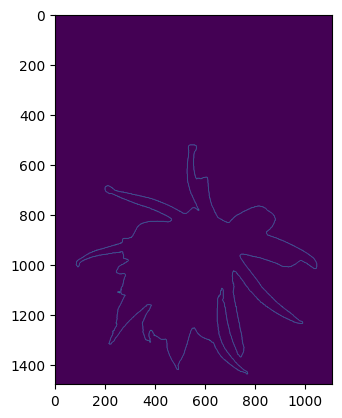

In [14]:
plt.imshow(traceIm)
plt.imsave('output/trace.png',traceIm)
plt.show()

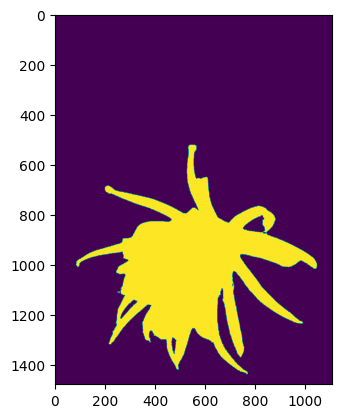

In [15]:
plt.imshow(roi)
plt.imsave('output/white.png',roi)
plt.show()

In [16]:
bgr = cv2.imread(imagepath)
gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
_, roi = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
cv2.imwrite('/home/dhanushka/stack/roi.png', roi)
cont = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
traceImFull = np.zeros(gray.shape, dtype=np.uint8)
cv2.drawContours(traceImFull, cont[0], -1, (255, 255, 255))

array([[255, 255, 255, ..., 255, 255, 255],
       [255,   0,   0, ...,   0,   0, 255],
       [255,   0,   0, ...,   0,   0, 255],
       ...,
       [255,   0,   0, ...,   0,   0, 255],
       [255,   0,   0, ...,   0,   0, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [17]:
# removing boundary
boundary = 255*np.ones(gray.shape, dtype=np.uint8)
boundary[1:boundary.shape[0]-1, 1:boundary.shape[1]-1] = 0

In [18]:
toremove = traceImFull & boundary
traceImFull = traceImFull ^ toremove

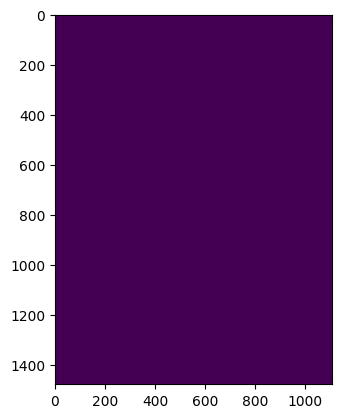

In [19]:
plt.imshow(traceImFull)
plt.imsave('output/traceFull.png',traceImFull)
plt.show()